# 모델2
- 텍스트를 보고 후보자 예측
- 입력 데이터(Feature)
    - 기사제목+댓글내용
- 출력 데이터(Label)
    - 박영선
    - 오세훈
    - 김영춘
    - 박형준

In [1]:
# 기본 라이브러리
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('seaborn-whitegrid')
import missingno
import re
import os
# 데이터
from sklearn.datasets import load_iris

# 경고메시지 제거
import warnings 
warnings.filterwarnings('ignore')

# KFold
from sklearn.model_selection import KFold # 순서대로 하거나 or 랜덤하게 클래스를 나눈다.
from sklearn.model_selection import StratifiedKFold # 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# 학습데이터와 검증데이터로 나누는 함수
from sklearn.model_selection import train_test_split

# 데이터 전처리
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
    
# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# 추가항목
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 비지도학습 - 군집
from sklearn.cluster import KMeans
from sklearn.cluster import mean_shift

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

# CNN
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, Conv1D
from keras.layers import MaxPooling2D, MaxPooling1D

# NLP
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# 문장을 단어 단위로 나누기
from keras.preprocessing.text import text_to_word_sequence
from keras.layers import Embedding

# 다중분류를 위한 원-핫 인코더
from keras.utils import to_categorical

# 더이상 성능 향상이 이루어지지 않는다면 조기 중단시킬 수 있는 함수
from keras.callbacks import EarlyStopping

# epoch마다 모델을 저장하는 함수
from keras.callbacks import ModelCheckpoint

# 파일로 저장된 딥러닝 모델을 객체로 복구하는 함수
from keras.models import load_model

# 저장
import pickle

# 시간 모듈
import time # 현재 시간값을 구할 수 있다.

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 13
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# GPU 메모리 사용량을 필요한 만큼만 증가하도록 설정

# 사용가능한 GPU 목록 가져오기
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # 필요한 만큼만 메모리를 사용할 수 있도록 설정하기
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# RandomSeed
np.random.seed(1)

## 데이터 불러오기

In [4]:
df = pd.read_csv('data/재보궐선거댓글데이터_최종.csv')
df

,제목,날짜,작성일,댓글,출처,"지역(서울:1, 부산:2)","정당(1:더불어민주당,2:국민의힘)","정당평가(부정;0, 긍정:1)",후보(기호 순),"후보평가(부정;0, 긍정:1)",제목댓글
0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-12 19:13:00,철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-09 13:49:00,박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."
2,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:42:00,빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되..."
3,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:38:00,서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당..."
4,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:02:00,부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이..."
...,...,...,...,...,...,...,...,...,...,...,...
144134,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:47:00,국민의힘 찍지 말라고 이 뉴스가 나온거임\n내냔에 국민의힘 찍을라 했드만 망했다 친...,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...
144135,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:41:00,굳이 일본과 해저터널 해야되는 이유가 없은이유\n-일본은고속도로비가 비싸다\n차라니...,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...
144136,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:38:00,도랏구나. 열도는 걍 갈라파고스로 남겨 둬라. 재난 난민 넘어 오면 귀찮다.,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...
144137,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:32:00,이걸 왜 하지? 우리한테 아무런 의미가 없는데,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...


## 데이터 전처리

In [67]:
# 사용할 데이터
df2 = df[['지역(서울:1, 부산:2)','후보(기호 순)','후보평가(부정;0, 긍정:1)',
          '정당(1:더불어민주당,2:국민의힘)','정당평가(부정;0, 긍정:1)','제목댓글']]
df2.columns = ['area','candidate','candidate_eval','party','party_eval','title_comment']

# 후보자를 구별하여 'area_candidate' 컬럼에 각 후보자 이름 추가

# 후보자별 인덱스 추출
ys_idx = df2.query('area == 1.0 & candidate == 1.0').index # 박영선 
sh_idx = df2.query('area == 1.0 & candidate == 2.0').index # 오세훈
yc_idx = df2.query('area == 2.0 & candidate == 1.0').index # 김영춘
hj_idx = df2.query('area == 2.0 & candidate == 2.0').index # 박형준
etc_idx = df2.query('candidate == 5.0').index # 기타

# 'area_candidate'컬럼에 후보자 이름값 추가
df2['area_candidate'] = np.nan
df2['area_candidate'][ys_idx] = '박영선'
df2['area_candidate'][sh_idx] = '오세훈'
df2['area_candidate'][yc_idx] = '김영춘'
df2['area_candidate'][hj_idx] = '박형준'
df2['area_candidate'][etc_idx] = '기타'

In [68]:
# 데이터 종류별 개수 확인
df2['area_candidate'].value_counts()

기타     1611
박영선    1303
오세훈    1178
박형준     211
김영춘      29
Name: area_candidate, dtype: int64

# 다중분류
- **활성화 함수**를 **이용**하려면 Y값이 **0-1로 이루어져** 있어야 함
    - 원-핫 인코딩(One-Hot Encoding)

## 1. 학습할 텍스트(docs) 지정

In [71]:
# 한글 정규표현식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [72]:
# 한글 외 문자열 공백처리
df2['title_comment'] = df2['title_comment'].apply(lambda x: text_cleaning(x))

In [73]:
# 후보자를 5가지로 분리가능한 데이터수
notnull_idx = df2[ df2['area_candidate'].notnull() ].index

# 후보자 예측에 사용될 feature 텍스트 선정
docs = df2['title_comment'][notnull_idx].to_list()
docs[:5]

['재보궐  부산 김영춘  박형준 서울도 양자 대결 박영선은 정동영이 얻은 프로선에 머무를것 이후 정권은 몰락의 길 페달을 급속히 밟을것이다',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 빵선이가서울시장되면서울은공산국가수도제의평양이될것이다',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국영국에 영주권자이므로박빵선이는대한민국사람이아니다빵선아사퇴해라부탁한다',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 문가 쫄개 박선 꼭 낙동강 오리알 만들어야 합니다 가족은 모두 외국 시민권 너도 여차하면 달아날 곳 만들어 놓고 놀구 있구나 문가와 함께 튈곳 만들어 놓았냐 서울 시민 여러분 화이팅 ',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 부산은 승기를 잡은 것 같습니다 실수를 하지않는 것이 중요하구요 서울은 반드시 단일화해야 합니다 오세훈이 바람직하지만 안되면 안철수라도 단일화를 해서 이겨야지요 단일화만 하면 이길 수 있습니다 가능하면 안철수의 양보를 요구합니다 그렇게 해서 문재인 정권을 심판해야 할 것입니다']

## 2. y값 문자열 Encoding

In [10]:
# 문자열 인코딩
encoder = LabelEncoder()
y = encoder.fit_transform(df2['area_candidate'][notnull_idx].values)
y

array([2, 2, 2, ..., 4, 0, 4])

In [11]:
# 인코딩값 확인
print( encoder.classes_ )
print( encoder.inverse_transform([0]) )
print( encoder.inverse_transform([1]) )
print( encoder.inverse_transform([2]) )
print( encoder.inverse_transform([3]) )
print( encoder.inverse_transform([4]) )

['기타' '김영춘' '박영선' '박형준' '오세훈']
['기타']
['김영춘']
['박영선']
['박형준']
['오세훈']


## 3. y값 One-Hot Encoding

In [12]:
y_encoded = to_categorical(y)
y_encoded.shape 

(4332, 5)

In [13]:
y_encoded # 출력층 노드의 개수는 5로 맞춰주기

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## 4. Tokenizer
- 텍스트를 잘게 나누는 것
- 단어별, 문장별, 형태소별, ...
- 이렇게 나누어진 하나의 단위를 **Token(토큰)**

In [14]:
token = Tokenizer() # 토큰화 함수 지정
token.fit_on_texts(docs) # 토큰화 함수에 문장 적용
print(token.word_index) # 각 단어에 매겨진 인덱스값 출력

{'서울시장': 1, '박영선': 2, '오세훈': 3, '보궐선거': 4, '내곡동': 5, '땅': 6, '후보': 7, '안철수': 8, '주영진의': 9, '토론': 10, '후보자': 11, '선거': 12, '원인첫': 13, '어땠나': 14, '박형준': 15, '마지막': 16, '민주당': 17, '윤석열': 18, '당신의': 19, '회': 20, '분토론': 21, '선택은': 22, '년': 23, '왜': 24, '서울': 25, '이': 26, '나경원': 27, '그': 28, '다': 29, '대선': 30, '또': 31, '하는': 32, '수': 33, '일': 34, '더': 35, '논란': 36, '것': 37, '부산시장': 38, '안': 39, '박원순': 40, '지지율': 41, '무슨': 42, '없다': 43, '토론회': 44, '할': 45, '대통령': 46, '성추행': 47, '여론조사와': 48, '오세훈이': 49, '등': 50, '한': 51, '측량때': 52, '다른': 53, '사람': 54, '보면': 55, '강경': 56, '여론조사박영선': 57, '있었냐가': 58, '윤석열의': 59, '몰랐다던': 60, '오세훈땅': 61, '잘': 62, '단일화': 63, '되면': 64, '있는': 65, '없는': 66, '이수봉': 67, '이런': 68, '다시보기': 69, '참': 70, '달리': 71, '너무': 72, '민심은': 73, '듯': 74, '앞서': 75, '더불어민주당': 76, '거짓말': 77, '인방': 78, '바닥': 79, '같은': 80, '합당': 81, '김진애': 82, '부산': 83, '분노': 84, '대통령이': 85, '고민정': 86, '부동산': 87, '된': 88, '문': 89, '앞두고': 90, '도대체': 91, '시장': 92, '좀': 93, '전': 94, '눈': 95, '하고': 96, '태풍의': 9

In [15]:
# 앞서 만든 토큰의 인덱스로만 채워진 새로운 배열 생성
X = token.texts_to_sequences(docs) 
print(X[0]) # 토큰화 후 인덱스로 채워진 새로운 배열
print(docs[0]) # 토큰화 전 실제 문장의 배열

[576, 83, 108, 15, 1356, 603, 817, 102, 4658, 1995, 8854, 8855, 1996, 904, 8856, 1704, 8857, 4659, 8858]
재보궐  부산 김영춘  박형준 서울도 양자 대결 박영선은 정동영이 얻은 프로선에 머무를것 이후 정권은 몰락의 길 페달을 급속히 밟을것이다


### 🤗 문장별 토큰 개수 파악

In [16]:
# 각 토큰으로 채워진 배열에서 최대 토큰수 찾기
max_len = 0
for i in X:
    if max_len <= len(i):
        max_len = len(i)
        
max_len

813

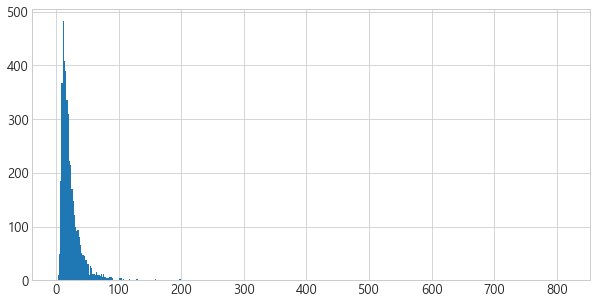

In [17]:
# 문장별 토큰 개수의 분포 확인
total_token_count = []
for i in X:
    total_token_count.append(len(i))

plt.hist( total_token_count, bins='auto' )
plt.show()

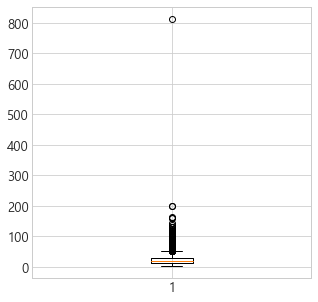

In [18]:
plt.figure(figsize=(5,5))
plt.boxplot(total_token_count)
plt.show() 

- 한 문장의 최대 토큰개수인 813개는 극단치라고 볼 수 있음
- 토큰의 수가 813인 데이터 제외

In [19]:
total_token_count.remove(813) # 극단치 제거

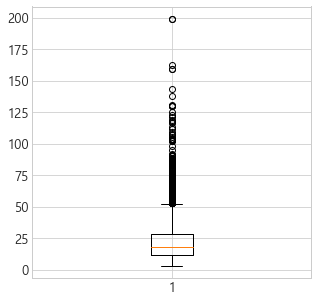

In [20]:
# 극단치인 813개의 토큰 제거 후 문장별 토큰개수 파악
plt.figure(figsize=(5,5))
plt.boxplot(total_token_count) 
plt.show() 

- 199도 극단치로 보임으로 199를 제거

In [145]:
total_token_count.remove(199) # 극단치 제거

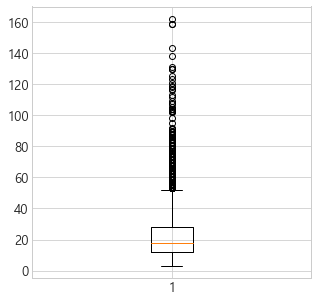

In [146]:
# 토큰 길이 199개를 2개 지우고 난 후의 분포
plt.figure(figsize=(5,5))
plt.boxplot(total_token_count) 
plt.show() 

In [147]:
# 토큰 개수의 분포 확인
pd.DataFrame(total_token_count, columns=['len(tokens)']).describe() 

,len(tokens)
count,4329.000000
mean,23.141141
std,16.710932
min,3.000000
25%,12.000000
50%,18.000000
75%,28.000000
max,162.000000


- **패딩(padding)** 시 맞춰주는 배열의 길이는 토큰의 최대길이 **162개**로 맞춰준다.
- **임베딩(embedding)** 시 배열을 압축할 때 사용하는 길이는 전체 문장의 75%가 포함되어 있는 토큰의 수인 **28**를 사용하여 압축한다.

## 5. 패딩(Padding)
- **딥러닝 모델**에 **입력**을 하려면 **학습 데이터의 길이가 동일**해야함. 패딩은 길이를 맞춰주는 작업
- 원하는 길이보다 짧은 부분은 숫자 0을 넣어 채우고,긴 데이터는 잘라서 같은 길이로 맞춘다.
- 한 문장의 토큰 개수 합이 가장 많은 것으로 채우는 것이 좋다.
- 따라서, 서로 다른 길이의 데이터를 **162**로 맞춘다.

In [24]:
padded_x = pad_sequences(X, 162)
padded_x # 배열의 길이가 맞춰짐

array([[   0,    0,    0, ..., 8857, 4659, 8858],
       [   0,    0,    0, ...,  603,  817, 8859],
       [   0,    0,    0, ...,  817, 8860, 8861],
       ...,
       [   0,    0,    0, ..., 2258, 8848,  745],
       [   0,    0,    0, ..., 2640, 1228, 8850],
       [   0,    0,    0, ..., 2441, 4560, 8853]])

## 6. 임베딩(Embedding)
- **주어진 배열을 정해진 길이로 압축**
- 텍스트를 원-핫 인코딩 시 벡터의 길이가 너무 길어지는 문제 해결


- **Embedding**( 입력, 출력, 단어수 )
    - **입력**: 총 몇 개의 단어 집합
    - **출력**: 몇 개의 임베딩 결과 사용할 것인지(임의)
    - **단어수**: 매번 입력될 단어 수는 몇 개로 할 것인지

In [25]:
# 총 몇 개의 '인덱스'가 '입력' 되어야 하는지 정하기
word_size = len(token.word_index) + 1 # 전체 단어 맨 앞에 0이 먼저 나와야 함.
word_size

36322

## 7. 모델 구조 생성/학습 및 저장
- 1. 기본 딥러닝
- 2. RNN(Recurrent Neural network, RNN)
    - **여러개의 데이터가 순서대로 입력**되었을 때 앞서 입력받은 데이터를 **잠시 기억**해놓는 방법. 그리고 기억된 데이터가 얼마나 **중요한지를 판단**하여 **별도의 가중치**를 줘서 다음 데이터로 넘기게 됨
    - **LSTM(Long Short Term Memory)**
        - RNN의 기울기 소실 문제라는 단점을 보완한 방법
        - 즉, 반복되기 직전에 다음 층으로 기억된 값을 넘길지 안 넘길지를 관리하는 단계 추가
- 3. CNN과 LSTM

### 기본 딥러닝 모델 구조 및 학습

In [27]:
# 모델 설정
model = Sequential()
model.add(Embedding( word_size, 28 , input_length=162 ) )
model.add(Flatten())
model.add(Dense(5, activation='softmax')) # 다중분류

# 모델 컴파일
model.compile( loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
             )

# 모델 저장 조건 설정
model_path = 'model/0409/{epoch}-{val_loss}.h5'
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
                               verbose=1,
                               save_best_only=True)
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=300)

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(padded_x, 
                                                     y_encoded, 
                                                     test_size=0.3, 
                                                     stratify=y_encoded)


# 모델 실행 및 저장
history = model.fit( X_train, y_train, validation_data=(X_test, y_test),
                    epochs=1500,
                    callbacks=[early_stopping_callback, checkpointer])

⇩ 여기부터 "8. 정확도 평가"까지는 제일 마지막에 실행한 **3.CNN과 LSTM**모델의 결과

In [138]:
# CNN+LSTM 모델
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 162, 28)           1017016   
_________________________________________________________________
dropout (Dropout)            (None, 162, 28)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 158, 64)           9024      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 162)               147096    
_________________________________________________________________
dense (Dense)                (None, 5)                 815       
Total params: 1,173,951
Trainable params: 1,173,951
Non-trainable params: 0
______________________________________________

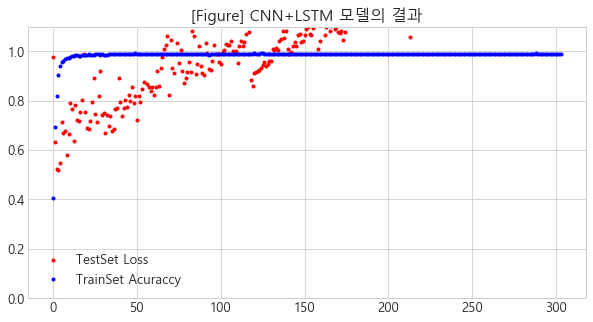

In [141]:
# 테스트셋으로 실험 결과의 오차값을 저장
y_vloss = history.history['val_loss']

# 학습셋으로 측정한 정확도의 값 저장
y_acc = history.history['accuracy']

# x값을 지정하고 그래프로 확인
x_len = np.arange(len(y_acc))
plt.title('[Figure] CNN+LSTM 모델의 결과')
plt.plot( x_len, y_vloss, 'o', c='red', markersize=3, label='TestSet Loss')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label='TrainSet Acuraccy')
plt.ylim(0,1.1)
plt.legend()
plt.show()

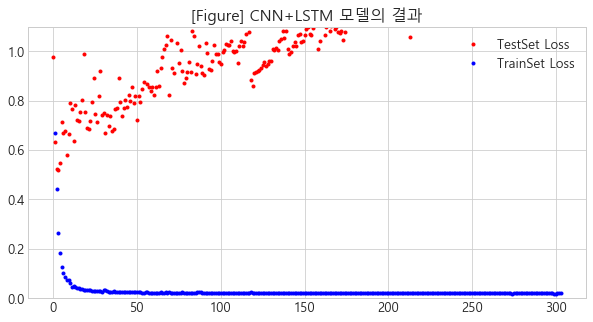

In [142]:
# 테스트셋으로 실험 결과의 오차값을 저장
y_vloss = history.history['val_loss']

# 학습셋으로 측정한 정확도의 값 저장
y_acc = history.history['loss']

# x값을 지정하고 그래프로 확인
x_len = np.arange(len(y_acc))
plt.title('[Figure] CNN+LSTM 모델의 결과')
plt.plot( x_len, y_vloss, 'o', c='red', markersize=3, label='TestSet Loss')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label='TrainSet Loss')
plt.ylim(0,1.1)
plt.legend()
plt.show()

## 8. 정확도 평가

In [143]:
# 훈련 데이터 정확도
print(model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(model.evaluate(X_test, y_test)[1])

95/95 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9901
0.9901055693626404
41/41 [==============================] - 0s 4ms/step - loss: 1.3248 - accuracy: 0.7438
0.7438461780548096


## 9. 저장한 모델 불러오기
- 테스트 데이터의 정확도가 가장 높은 **1. 기본 딥러닝 모델**을 불러와 사용

In [122]:
best_model = load_model('./model/0409/model2_1637/21-0.39536339044570923.h5')

In [144]:
# 훈련 데이터 정확도
print(best_model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(best_model.evaluate(X_test, y_test)[1])

95/95 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9977
0.99769127368927
41/41 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.8600
0.8600000143051147


## 10. 학습하지 않은 데이터로 후보자 예측

In [124]:
# 학습하지 않은 데이터의 인덱스 번호
null_idx = df2[df2['candidate'].isnull()].index

# 예측 대상인 텍스트 데이터 분리
docs2 = list(df2.iloc[null_idx]['title_comment'])
docs2[:5]

['재보궐  부산 김영춘  박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마음으로 물러서라',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은 오거돈재산 불려줄려고 문재인과 민주당들이 발악아닌가다 부산사람이 하는말 이번선거는 쎄빠지게 오거돈위한선가아이가다',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당 빼고 지들 성범죄로 선거하는데 선가비 토안하는 비 양심 정당님',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 어떻게든 문재인 정권 졸개들 박살 내야 합니다 성희롱 범들 얼굴이 두껍다 생각 안하나 이번에 뭉가 박살 내지 않으면 계속 국민 알기를 졸로 볼 것입니다 서울부산 시민 여러분  ',
 '재보궐  부산 김영춘  박형준 서울도 양자 대결 좌파 당선 도우미 안철수가 과연']

In [125]:
# 앞서 만든 토큰의 인덱스로만 채워진 새로운 배열 생성
X2 = token.texts_to_sequences(docs2) 

In [126]:
print(X2[0])
print(docs2[0])

[576, 83, 108, 15, 1356, 603, 817, 1522, 210, 3692]
재보궐  부산 김영춘  박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마음으로 물러서라


In [127]:
# 기존 토큰의 인덱스로 채워진 배열의 값 확인
for key, val  in  token.word_index.items():
    if val in [576, 83, 108, 15, 1356, 603, 817, 1522, 210, 3692]:
        print(key)

박형준
부산
김영춘
말고
재보궐
양자
대결
서울도
철수야
마음으로


In [128]:
# 패딩
padded_x2 = pad_sequences(X2, 162)
padded_x2.shape

(139776, 162)

In [129]:
# 예측하기
y_pred_label = np.argmax(best_model.predict(padded_x2), axis = 1)
y_pred_label

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [130]:
# 결과 디코딩
y_pred = encoder.inverse_transform(y_pred_label)
y_pred

array(['박영선', '박영선', '박영선', ..., '기타', '기타', '기타'], dtype=object)

In [131]:
y_pred[12]

'박영선'

In [132]:
docs2[12]

'재보궐  부산 김영춘  박형준 서울도 양자 대결 박원순의 성폭력 자살을 공수처에 수사의뢰하고 더불더듬당의 후보를 즉각 사퇴시켜라 부끄러움도 상식도 예의도 없는 집단에게 어찌 서울을 맡기겠는가'

In [133]:
# 결과값 확인
pd.Series(y_pred).value_counts()

기타     67716
박영선    41861
오세훈    29492
박형준      677
김영춘       30
dtype: int64

In [90]:
# 예측한 후보값 넣기
df2['area_candidate'][null_idx] = y_pred

In [93]:
df2.to_csv('data/0409/재보궐선거댓글데이터_최종_by_model2.csv',encoding='utf-8-sig')